# openEO User Workshop - Guided Session: Multi-Source Data Fusion With openEO Python Client

_October 19th, 2020 - Virtual Workshop (https://openeo.org/news/2020-09-02-openeo-user-workshop.html)_

## Introduction

Phenology is an important supporting parameter of vegetation that can be derived from remote sensing data. It allows for instance to evaluate crop conditions in agriculture, or vegetation/crop type mapping and is an indicator for climate change. In this case, phenology is defined by:

* Start of season, a date and the corresponding value of the biophysical indicator
* End of season, a date and the corresponding value of the biophysical indicator

Deriving phenology accurately requires a vegetation index time series for a given pixel or area, 
that has both a sufficiently *high spatial resolution* (to avoid noise from sampling heterogeneous areas in a pixel or area)
and a sufficiently *high temporal accuracy*.
Today, no single sensor can really satisfy all these requirements, limiting the accuracy of the predicted phenology parameters.

In this openEO use case, we will demonstrate openEO's capability to implement a *multi sensor data fusion approach*
that merges the following datasets (with different spatial and temporal resolutions)
into a single dense vegetation index time series:

* ProbaV 10-daily composites: low spatial resolution (300m), but high temporal resolution
* Sentinel-2: high spatial resolution (10m), low temporal resolution
* Sentinel-1 Gamma0: high spatial and temporal resolution, but no direct link to phenological parameters

The resulting fused time series is then provided as input to a phenology algorithm,
implemented as a User-Defined Function (UDF), so that it can be easily replaced with other implementations. 

## Overview of the algorithm 

Below we give a step-by-step overview of the workflow, together with the most important openEO processes that were used to implement them.

1. Preprocessing Sentinel-2 data
  * Load scene classification (`load_collection`)
  * Load bands 8 and 4 (`load_collection`)
  * Transform scene classification to binary cloud mask (`reduce_dimension`)
  * Dilate cloud mask (`apply_kernel`)
  * Mask bands 8 and 4 (`mask`)
  * Compute NDVI (`ndvi` or band math through `reduce_dimension`)
2. Merging Sentinel-1 Gamma0: (`load_collection`/`resample_cube_spatial`/`merge_cubes`)
3. Preprocessing and merging PROBA-V 10-daily composites to Sentinel-2 resolution (`load_collection`/`resample_cube_spatial`/`mask_polygon`/`merge_cubes`)
4. Apply Deep learning model (GAN) to generate single NDVI (`apply_neighborhood`/`run_udf`)
5. Pixel wise smooth the resulting time series using Savitzky–Golay filter
6. Pixel wise derivation of phenological parameters (`apply_dimension`/`run_udf`)


## Setup

This exercise is provided as a Jupyter notebook, 
but it's also possible to copy the necassary snippets into regular Python script.
You can run your own Jupyter(Lab) environment 
or use a managed/hosted Jupyter(Lab) environment like https://notebooks.terrascope.be
(note that you typically need a registered account for this).

Basically you just need a Python (3.6 or higher) environment and the ability to install packages into that environment.

### Dependencies

Let's start with importing the most important packages we will be using, to get the dependency headaches out of the way.

If any of these imports does not work, make sure to install the related package in the Python environment of the Jupyter kernel you are using.
Most importantly for this demonstration: install `openeo`, the [openEO Python Client Package](https://github.com/Open-EO/openeo-python-client).
If you have direct (Bash) shell access to the Python environment of your Jupyter kernel, just use pip from the command line, for example to install the latest version of `openeo`:

    pip install --upgrade openeo

If you are not sure about your Jupyter kernel's Python environment,
it is also possible to install packages directly from Jupyter code cells, with a snippet like this:

    import sys
    !{sys.executable} -m pip install --upgrade openeo



In [1]:
import numpy
import scipy.signal
import shapely
import openeo
import rasterio
from matplotlib import pyplot as plt
%matplotlib inline

Check that the `openeo` package version is recent enough.
The latest release at time of this writing is `0.4.6`.

In [2]:
openeo.client_version()

'0.4.7a1'

For debugging, or to better see what is going on behind the scenes: increase the log level to `DEBUG`. 
(Note that it might be necessary to restart the kernel for `basicConfig` to have effect.)

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

## openEO Backend Connection and Authentication

The entry point for interacting with a certain openEO backend (defined by a backend URL) is a `Connection`.
To do anything non-trivial you also need to authenticate with user credentials, which will be provided during the workshop session.
Future warning: backends will allow you to log in with your institution (edugain) or social accounts. 
This will make demo credentials invalid. Always avoid sharing your credentials with others!

The full phenology algorithm implemented in this notebook depends on available collections and functionallity
provided by the VITO openEO backend at https://openeo.vito.be/.
However, some parts and examples can also be tried against other openEO backends,
but keep in mind that input data collection names have to be altered then.
Other backends can be explored at https://hub.openeo.org/.





In [4]:
backend_url = "https://openeo.vito.be"


In [6]:
vito_conn = openeo.connect(backend_url)
vito_conn.authenticate_basic()

This connection object allows to explore the available collections, processes, file formats, secondary services, etc on the backend.

Try out various `list_` methods here (see https://open-eo.github.io/openeo-python-client/api.html#module-openeo.rest.connection).

In [ ]:
vito_conn.list_ EXPLORE HERE

## Input: Area and Time Range of Interest

A small field will be used near the location of VITO Remote Sensing as shown in the figure. This area contains several fields cultivated for different type of crops (varying start and end of seasons), hence it is ideal candidate for showcasing the process chain. 

In [7]:
bbox = {
    'west': 5.017099,
    'south': 51.219585,
    'east': 5.023468,
    'north': 51.223363,
    'crs': 'EPSG:4326',
}

bbox_polygon = shapely.geometry.Polygon.from_bounds(bbox["west"], bbox["south"], bbox["east"], bbox["north"])

In [8]:
from IPython.display import display, Image
display(Image(url='https://github.com/Open-EO/openeo-usecases/raw/master/vito_phenology_usecase/notebook/img/single_field.png'))

The season of 2019 will be analysed. Because both the fusion works with a large buffer around a given coordinate, the date range starts in the previous year and ends in the next.

In [9]:
year = 2019
startdate = str(year - 1) + '-10-01'
enddate = str(year + 1) + '-07-01'
startdate, enddate

('2018-10-01', '2020-07-01')

## Step 1. Preprocessing Sentinel-2 data (`load_collection`/`band`/`mask`/`apply_kernel`/`ndvi`/`reduce_dimension`)


OpenEO is designed such that:
-   first a processing chain is assembled client side. This "process" (also called "process graph" under the hood) is just a symbolic representation. 
    Only the collection metadata is obtained from the backend (to learn dimension names and band names), no actual calculation is performed.
-   This process is then submitted to the backend, which performs the actual computations. 


We start with loading a Sentinel-2 data: bands 4 (red) and 8 (NIR) as a collection
and a separate "scene classification" layer.
This creates our initial `DataCube` objects, which will be manipulated in the following steps.

In [10]:
# A cube with 2 bands: red and NIR
S2bands = vito_conn.load_collection('TERRASCOPE_S2_TOC_V2', bands=['TOC-B04_10M', 'TOC-B08_10M'])

# A separate band with scene classification classes.
s2_sceneclassification = vito_conn.load_collection('TERRASCOPE_S2_TOC_V2', bands=['SCENECLASSIFICATION_20M']).band('SCENECLASSIFICATION_20M')

S2bands

Transform the scene classification to a binary cloud mask. This is done by using a fuzzy mask approach:
* selecting the pixels to be masked based on the classification types (we want to keep classes like "vegetation" and "water" and mask "cloud" classes)
* clean up the mask a bit by dilating it by a few pixel using a gaussian blur and select by threshold

In [11]:
import numpy 
import scipy.signal

def makekernel(size: int) -> numpy.ndarray:
    assert size % 2 == 1
    kernel_vect = scipy.signal.windows.gaussian(size, std=size / 6.0, sym=True)
    kernel = numpy.outer(kernel_vect, kernel_vect)
    kernel = kernel / kernel.sum()
    return kernel

def create_advanced_mask(band):
    # in openEO, 1 means mask (remove pixel) 0 means keep pixel
    classification = band

    # Keep useful pixels (4=vegetation, 5=not vegetated, 6=water, 7=unclassified)
    first_mask = ~ ((classification == 4) | (classification == 5) | (classification == 6) | (classification == 7))
    # Clean up mask with gaussian blur+threshold.
    first_mask = first_mask.apply_kernel(makekernel(9))
    first_mask = first_mask.add_dimension("bands", "mask", type="bands").band("mask")
    first_mask = first_mask > 0.057

    # Remove cloud pixels (3=cloud shadows, 8=cloud medium prob, 9=cloud high prob, 10=thin cirrus)
    second_mask = (classification == 3) | (classification == 8) | (classification == 9) | (classification == 10)
    # Clean up mask with gaussian blur+threshold.
    second_mask = second_mask.apply_kernel(makekernel(81))
    second_mask = second_mask.add_dimension("bands", "mask", type="bands").band("mask")
    second_mask = second_mask > 0.1

    return first_mask.filter_temporal(startdate, enddate) | second_mask.filter_temporal(startdate, enddate)

S2mask = create_advanced_mask(s2_sceneclassification)

Apply the mask to the cube with the red and NIR bands:

In [12]:
S2bands = S2bands.mask(S2mask)

Compute the NDVI. There is a dedicated ["ndvi" process](https://openeo.org/documentation/1.0/processes.html#ndvi) for this, directly available on the `DataCube` object:

In [13]:
S2ndvi = S2bands.ndvi()

It is also possible to calculate the NDVI more explicitly using the "band math" feature provided by the `openeo` Python client.
It allows to express the band calculations directly as easy to read Python code.
See https://open-eo.github.io/openeo-python-client/basics.html#example-simple-band-math for inspiration.

In [ ]:
red = S2bands.band('TOC-B04_10M')
nir = S2bands.band('TOC-B08_10M')
# Calculate NDVI here, using the `red` and `nir` "variables":
S2ndvi = ENTER CALCULATIONS HERE

## Simple download example

_Learning goal: learn how to work in an interactive manner, and debug your code._

The notebook constructs a complex workflow, but when developing and debugging, you often want to check intermediate results.
Please try this.

Tip: this notebook works on Terrascope data. You can explore the Sentinel-2 layer here:
https://viewer.terrascope.be/?language=en&bbox=2.798217823728918,50.43992723836223,6.313842823728918,51.59490312270836&overlay=true&bgLayer=Satellite&date=2018-05-06&layer=CGS_S2_RADIOMETRY


### Download image 

Download a small area of the NDVI datacube we calculated (`S2ndvi`). 
Optionally: also download the scene classification layer (`s2_sceneclassification`)

Tips: 
- 2018-05-06 has nice cloud free data!
- you can easily reuse the bounding box we defined before with `.filter_bbox(**bbox)`
- You will have to choose a format:
    - GTiff (GeoTiff) is suitable for single dates, but does not support timeseries very well. (It will return data for some date.)
    - NetCDF does support full timeseries, but the format is somewhat more complex.
- API docs: https://open-eo.github.io/openeo-python-client/basics.html#example-simple-band-math

In [ ]:
S2ndvi. CALCULATE AND DOWNLOAD HERE

(1, 44, 44)


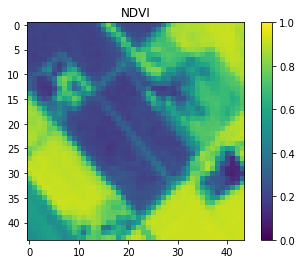

In [15]:
# Show the downloaded image
with rasterio.open("simple_download_ndvi.tif", "r") as ds:
    img = ds.read()

plt.imshow(img[0], vmin=0, vmax=1)
plt.title("NDVI")
plt.colorbar()

print(img.shape)

### Download timeseries

Downloading an aggregated timeseries for an area of interest is another great way to explore a dataset. 
It can give you a sense of how much data is available, and how the signal behaves for your area of interest.
See the example at https://open-eo.github.io/openeo-python-client/basics.html#example-retrieving-aggregated-timeseries for inspiration


**Warning**
- When debugging, it is recommmended to always work on small areas and date ranges. This improves interactivity, and avoids a network timeout when connecting with the backend.
-  When you do experience timeouts, and tuning parameters does not work, have a look at using batch jobs:
https://open-eo.github.io/openeo-python-client/basics.html#managing-jobs-in-openeo
- Note that the performance of requests can depend on the backend!

In [16]:
from openeo.rest.conversions import timeseries_json_to_pandas
import pandas as pd

In [ ]:
ndvi_timeseries = S2bands.CALCULATE AND EXECUTE HERE

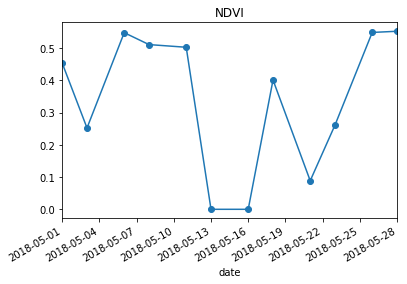

In [18]:
from openeo.rest.conversions import timeseries_json_to_pandas
import pandas as pd
s = timeseries_json_to_pandas(ndvi_timeseries)
s.index = pd.to_datetime(s.index)
s.plot(marker='o', title="NDVI")

### Another backend

Try to do the same exercises against another openEO backend.




## Step 2. Merging Sentinel-1 Gamma0 (`load_collection`/`resample_cube_spatial`/`merge_cubes`)

Now we merge the Sentinel-2 based NDVI data with Sentinel-1 data using the `merge_cubes` process and `resample_cube_spatial` to properly align both cubes.

In [19]:
S1bands = vito_conn.load_collection('TERRASCOPE_S1_GAMMA0_V1', bands=['VH', 'VV'])
S1bands = S1bands.resample_cube_spatial(S2ndvi)

# To merge properly both cubes need same set of dimensions, so we add a "band" dimension again to the NDVI cube.
merged_cube = S2ndvi.add_dimension("bands", "S2ndvi", type="bands").merge_cubes(S1bands)

## Step 3. Preprocessing and merging PROBA-V 10-daily composites to Sentinel-2 resolution(`load_collection`/`resample_cube_spatial`/`merge_cubes`/`mask_polygon`)

The Sentinel-2 data has 10m resolution, while the PROBA-V images are at 300m. Therefore a resampling has to be performed before the two data sources can be merged into a single dataset. 

The masking to the bounding box (`mask_polygon(bbox_polygon)`) helps to optimize the process and restrict resampling to the area of interest.

In [20]:
PVndvi = vito_conn.load_collection('PROBAV_L3_S10_TOC_NDVI_333M', bands=['ndvi'])
PVndvi = PVndvi.resample_cube_spatial(S2ndvi)
PVndvi = PVndvi.mask_polygon(bbox_polygon)
merged_cube = merged_cube.merge_cubes(PVndvi)

## Spatio-temporal constraints

Finally, by specifying the date range and bounding box, the merged cube will be ready for the data fusion step.

In [21]:
merged_field_cube = merged_cube.filter_temporal(startdate, enddate).filter_bbox(**bbox)

## Using User Defined Functions (UDF) in openEO


At this point, you know how to use so called 'predefined' functions, and are able to download and inspect intermediate results.
The next level of usage is mastering user defined functions: https://open-eo.github.io/openeo-python-client/udf.html

This example uses two UDF's: one that users Tensorflow, the other one applies Szavitky Golay smoothing.
Try to understand how this works, or adjust them if you feel like a challenge!



### Step 4. Apply deep learning model (GAN) to generate single NDVI (`apply_neighborhood`/`run_udf`)

The idea is that gaps in the Sentinel-2 NDVI are filled with information from the other sources. This is achieved by using a previously trained a GAN model (generative adversarial network). This is a technique that is able to reconstruct realistic looking photographs, but has also proven its use in scientific applications. 

The current model is designed such that it takes a spatio-temporal datacubes of 128x128 pixel area for all inputs with an overlap of 16 pixels. Hence, it can combine information provided by a time series of a pixel, as well as the local spatial neighbourhood of a pixel. In openEO this chunked processing can be done with the `apply_neighborhood` process.

The model itself is not included in the use case code, we simply load a pre-designed architecture with the weights. This demonstrates the ability of openEO to integrate with modern machine learning libraries like Tensorflow.

Runtime parametrization of a UDF is under development at the moment, therefore simple string substitution approach was used (the UDFString class).

In [22]:
from pathlib import Path
import re
import requests

class UDFString():
    def __init__(self, filename):
        if filename.startswith("https://"):
            self.value = requests.get(filename).text
        else:
            with open(filename, 'r+') as f:
                self.value = f.read()
    def replace_option(self,option,new_value):
        self.value=re.sub('(\n\s*'+option+'\s*=).*\n','\\1 '+new_value+'\n',self.value,count=1)
        return self

# Model weights (path to file on computing cluster)
openeo_model= '/data/users/Public/banyait/usecase_multisource_data_fusion/gan_model.h5'
udf_url = "https://raw.githubusercontent.com/Open-EO/openeo-usecases/master/vito_phenology_usecase/notebook/udf/udf_gan.py"
gan_udf_code = UDFString(udf_url).replace_option('prediction_model', '"'+openeo_model+'"').value

ndvi_cube = merged_field_cube.apply_neighborhood(lambda data: data.run_udf(udf=gan_udf_code, runtime='Python'), size=[
    {'dimension': 'x', 'value': 112, 'unit': 'px'},
    {'dimension': 'y', 'value': 112, 'unit': 'px'}
], overlap=[
    {'dimension': 'x', 'value': 8, 'unit': 'px'},
    {'dimension': 'y', 'value': 8, 'unit': 'px'}
])
ndvi_cube=ndvi_cube.add_dimension("bands", "ndvi", type="bands").band("ndvi")

### Step 5. Pixel-wise smoothing of the time series using Savitzky–Golay filter (`apply_dimension`/`run_udf`)

In this step we want to smooth the data along the temporal dimension, independently on every pixel.
We will use the standard [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) from the SciPy package.
The illustration below shows the effect on some example points from the field.

In [23]:
display(Image(url="https://github.com/Open-EO/openeo-usecases/raw/master/vito_phenology_usecase/notebook/img/gan.png"))

### Step 6. Pixel wise derivation of phenological parameters (`apply_dimension`/`run_udf`)

Derives phenological parameters at pixel level from the dense NDVI time series. Over the season the NDVI value grows as the plants grew and at the end of the season it drops at harvest time. For this demonstration, we choose a very simple implementation which in essence just searches for the local minimums. More advanced implementations are available, for instance by using the Timesat library. 

In [24]:
display(Image(url="https://github.com/Open-EO/openeo-usecases/raw/master/vito_phenology_usecase/notebook/img/pheno.png"))

### Combined execution of smoothing and phenology

While it is technically possible in openEO to implement the Savitzky-Golay filtering and phenology parameter estimation
in dedicated UDF, we will combine the calculation in a single UDF for performance reasons.

In [25]:
udf_url = "https://raw.githubusercontent.com/Open-EO/openeo-usecases/master/vito_phenology_usecase/notebook/udf/udf_savitzkygolaysmooth_phenology.py"
udf = openeo.UDF(UDFString(udf_url).value)

phenology_cube = ndvi_cube.apply_dimension(process=udf, dimension='t')

## Final "cube"


With this `phenology_cube`, we completed building the openEO "process". 

We can inspect the "process graph" we will send to the backend for execution.
For example, let's dump it in a JSON file:

In [26]:
import json
with open('phenology_graph.json','w') as f:
    json.dump(phenology_cube.flatten(), f, indent=2)

## Executing the process

A process can either be excuted via synchronous or batch mode. 
* **synchronous mode** keeps the HTTP connection open and is intended for small/quick calculations (if the calculation takes to long or the result is too large, the connection and related data might be lost)
* **batch mode** allows to run long lasting, large jobs while detaching and reconnecting for the results later

Let's choose GeoTIFF for the format of the results.

In [27]:
%%time
# Synchronous mode
# phenology_cube.download("eos_sos.tif", format='GTiff')


# Batch job mode
job_options = {'driver-memory': '4G', 'executor-memory': '4G'}
phenology_cube.execute_batch("eos_sos.tif", out_format='GTiff', job_options=job_options, parameters={"tiled":True})

0:00:00.000003 Job '724af522-bf40-45ed-82a3-d121542232a3': created (progress N/A)
0:00:05.162425 Job '724af522-bf40-45ed-82a3-d121542232a3': created (progress N/A)
0:00:11.537323 Job '724af522-bf40-45ed-82a3-d121542232a3': created (progress N/A)
0:00:19.469895 Job '724af522-bf40-45ed-82a3-d121542232a3': created (progress N/A)
0:00:29.581864 Job '724af522-bf40-45ed-82a3-d121542232a3': queued (progress N/A)
0:00:41.917892 Job '724af522-bf40-45ed-82a3-d121542232a3': queued (progress N/A)
0:00:57.433825 Job '724af522-bf40-45ed-82a3-d121542232a3': queued (progress N/A)
0:01:16.745062 Job '724af522-bf40-45ed-82a3-d121542232a3': queued (progress N/A)
0:01:40.997841 Job '724af522-bf40-45ed-82a3-d121542232a3': running (progress N/A)
0:02:11.682771 Job '724af522-bf40-45ed-82a3-d121542232a3': running (progress N/A)
0:02:49.169831 Job '724af522-bf40-45ed-82a3-d121542232a3': running (progress N/A)
0:03:36.525825 Job '724af522-bf40-45ed-82a3-d121542232a3': running (progress N/A)
0:04:35.470000 Job '

<RESTJob job_id='724af522-bf40-45ed-82a3-d121542232a3'>

## Results
After a successful run the resulting image will contain two bands: start and end of season values as day of years.

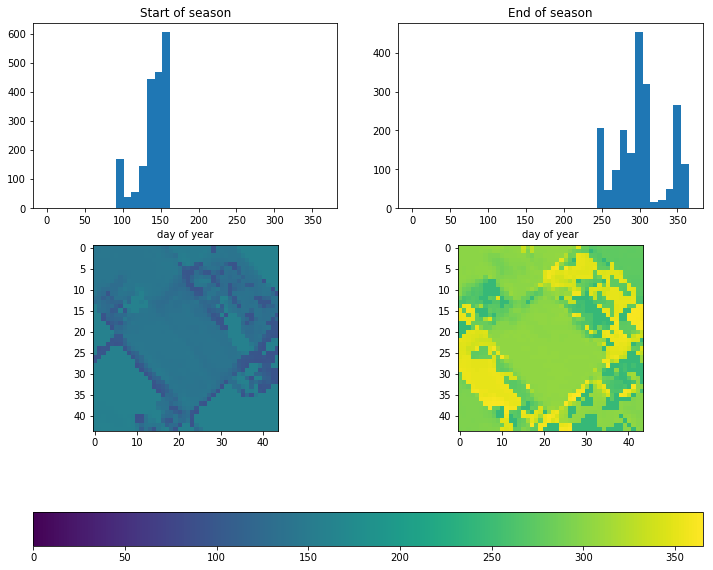

In [28]:
with rasterio.open('eos_sos.tif', 'r') as ds:
    img = ds.read()  

fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)

axes[0, 0].set_title("Start of season")
axes[0, 0].hist(img[0].flat, bins=3*12, range=(0,365))
axes[0, 0].set_xlabel("day of year")
im0 = axes[1, 0].imshow(img[0], vmin=0, vmax=365)

axes[0, 1].set_title("End of season")
axes[0, 1].hist(img[1].flat, bins=3*12, range=(0,365))
axes[0, 1].set_xlabel("day of year")
im1 = axes[1, 1].imshow(img[1], vmin=0, vmax=365)

fig.colorbar(im0, ax=axes, orientation='horizontal', fraction=.1)

## Play around

If you've gotten here, you've already mastered the most important openEO concepts, so play around, read the docs, and see where it gets you.